In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [2]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [3]:
# data load
df_name = 'freesolv'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['CN(C)C(=O)c1ccc(cc1)OC', 'CS(=O)(=O)Cl', 'CC(C)C=C', 'CCc1cnccn1', 'CCCCCCCO']
0   -11.01
1    -4.87
2     1.83
3    -5.45
4    -4.21
Name: freesolv, dtype: float64


In [4]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [5]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.429183,0.002457,11.429183,0.002457,0.686360,179.219,166.115,179.094629,70,0,...,0,0,0,0,0,0,0,0,0,-11.01
1,9.397377,-3.194444,9.397377,0.925154,0.421427,114.553,111.529,113.954228,32,0,...,0,0,0,0,0,0,0,0,0,-4.87
2,3.560185,0.648148,3.560185,0.648148,0.412737,70.135,60.055,70.078250,30,0,...,0,0,0,0,0,0,0,0,0,1.83
3,4.034722,0.966111,4.034722,0.966111,0.536795,108.144,100.080,108.068748,42,0,...,0,0,0,0,0,0,0,0,0,-5.45
4,8.365587,0.364796,8.365587,0.364796,0.544191,116.204,100.076,116.120115,50,0,...,0,0,0,0,0,0,0,3,0,-4.21


# t-sne

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## 사분위수

In [7]:
Q1 = np.percentile(target, 25)
Q2 = np.percentile(target, 50)
Q3 = np.percentile(target, 75)

idx_Q1 = np.where(target < Q1)[0]
idx_Q2 = np.where((target >= Q1) & (target < Q2))[0]
idx_Q3 = np.where((target >= Q2) & (target < Q3))[0]
idx_Q4 = np.where(target >= Q3)[0]

print(Q1, Q2, Q3)
print(idx_Q1, idx_Q2, idx_Q3, idx_Q4)

-5.7275 -3.5300000000000002 -1.2149999999999999
[  0   5  18  20  21  29  32  33  35  40  42  44  52  53  56  58  63  66
  69  71  72  74  79  82  83  89  91  98  99 113 117 118 121 124 128 151
 152 154 157 161 163 171 178 190 191 197 198 201 209 210 212 213 215 227
 237 238 243 246 247 254 266 267 276 279 280 283 293 297 308 309 311 323
 324 325 328 333 334 336 344 349 357 362 364 375 377 384 387 389 390 391
 394 397 398 404 405 406 409 413 414 416 421 422 423 428 436 440 441 443
 444 449 460 462 464 465 467 469 470 472 476 478 479 481 485 492 512 513
 515 516 522 523 537 538 541 543 545 547 549 555 557 558 561 571 575 576
 577 578 582 589 602 603 604 609 612 614 616 618 623 625 627 636 639] [  1   3   4   7   9  11  12  15  22  23  24  26  34  37  46  47  48  49
  51  57  59  60  61  75  77  90  93  94  96 102 103 109 110 119 122 125
 126 131 133 138 143 147 158 159 164 169 170 172 173 175 179 183 186 192
 200 204 211 217 226 229 230 232 233 239 244 245 249 251 258 262 264 269
 275 2

In [8]:
# 중앙값
med = np.percentile(target, 50)

idx_med1 = np.where(target < med)[0]
idx_med2 = np.where(target >= med)[0]

print(med)
print(idx_med1, idx_med2)

-3.5300000000000002
[  0   1   3   4   5   7   9  11  12  15  18  20  21  22  23  24  26  29
  32  33  34  35  37  40  42  44  46  47  48  49  51  52  53  56  57  58
  59  60  61  63  66  69  71  72  74  75  77  79  82  83  89  90  91  93
  94  96  98  99 102 103 109 110 113 117 118 119 121 122 124 125 126 128
 131 133 138 143 147 151 152 154 157 158 159 161 163 164 169 170 171 172
 173 175 178 179 183 186 190 191 192 197 198 200 201 204 209 210 211 212
 213 215 217 226 227 229 230 232 233 237 238 239 243 244 245 246 247 249
 251 254 258 262 264 266 267 269 275 276 277 279 280 283 290 293 297 298
 300 305 307 308 309 310 311 314 318 320 323 324 325 326 328 331 333 334
 336 344 347 349 350 351 352 354 357 358 360 362 364 366 368 369 374 375
 377 378 384 387 389 390 391 392 393 394 396 397 398 399 402 404 405 406
 407 409 410 413 414 416 418 419 421 422 423 425 428 429 432 435 436 437
 440 441 443 444 449 450 452 458 460 462 464 465 466 467 469 470 472 476
 478 479 480 481 482 483 484 48

In [9]:
# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)

idx_med4 = np.where(target < med1)[0]
idx_med5 = np.where((target >= med1) & (target < med2))[0]
idx_med6 = np.where(target >= med2)[0]

print(med1, med2)
print(idx_med4, idx_med5, idx_med6)

-4.7747 -2.2788
[  0   1   3   5  15  18  20  21  22  29  32  33  35  40  42  44  47  49
  52  53  56  58  63  66  69  71  72  74  79  82  83  89  91  98  99 113
 117 118 121 124 125 128 133 147 151 152 154 157 158 159 161 163 170 171
 178 190 191 197 198 201 209 210 212 213 215 227 229 237 238 243 244 245
 246 247 251 254 258 264 266 267 276 279 280 283 293 297 300 307 308 309
 311 318 320 323 324 325 328 331 333 334 336 344 347 349 354 357 362 364
 366 369 375 377 378 384 387 389 390 391 393 394 396 397 398 399 404 405
 406 407 409 410 413 414 416 421 422 423 425 428 429 435 436 440 441 443
 444 449 450 452 460 462 464 465 467 469 470 472 476 478 479 480 481 485
 492 500 510 512 513 514 515 516 522 523 529 537 538 541 543 544 545 547
 549 554 555 557 558 561 570 571 575 576 577 578 582 588 589 602 603 604
 609 612 613 614 616 618 619 623 625 627 636 638 639 641] [  4   7   9  11  12  13  14  23  24  25  26  27  28  34  37  38  45  46
  48  51  57  59  60  61  68  73  75  77  80  90  

In [10]:
X = np.array(df_all_features)

In [29]:
perplexity = 30
method = 'barnes_hut' 
# default: barnes_hut, 'exact'

In [30]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method)
X_tsne = tsne.fit_transform(X)

tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method)
X_tsne3D = tsne3D.fit_transform(X)


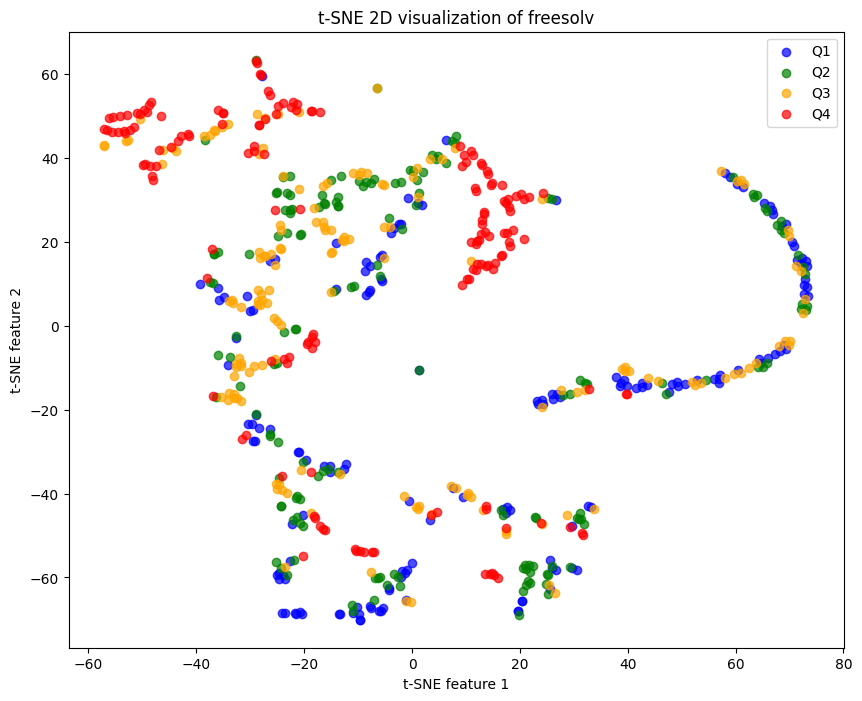

In [13]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.scatter(X_tsne[idx_Q1, 0], X_tsne[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_Q2, 0], X_tsne[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax.scatter(X_tsne[idx_Q3, 0], X_tsne[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax.scatter(X_tsne[idx_Q4, 0], X_tsne[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax.set_title(f't-SNE 2D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend()
plt.show()

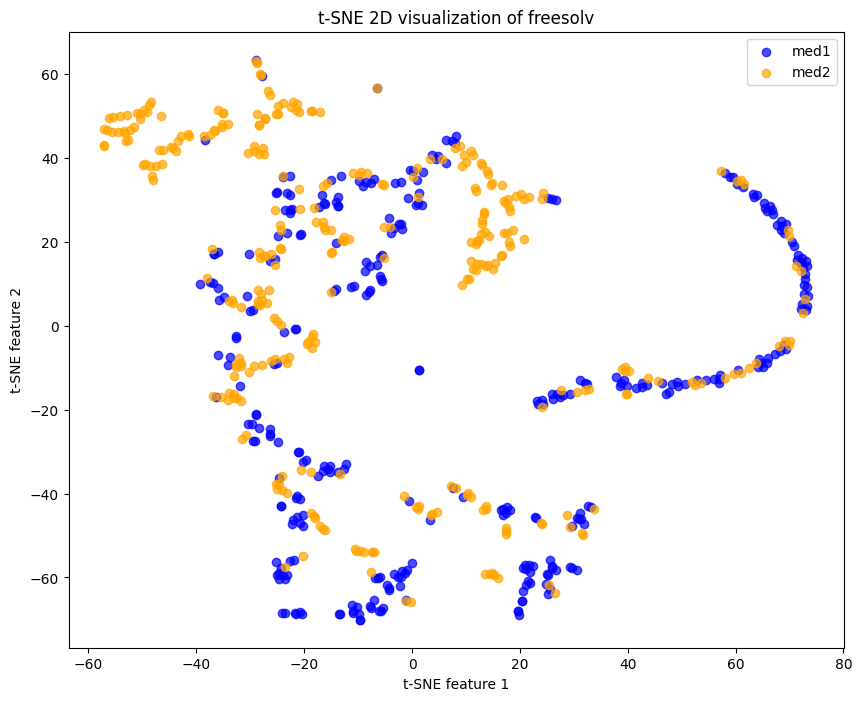

In [14]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.scatter(X_tsne[idx_med1, 0], X_tsne[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_med2, 0], X_tsne[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 2D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend()
plt.show()

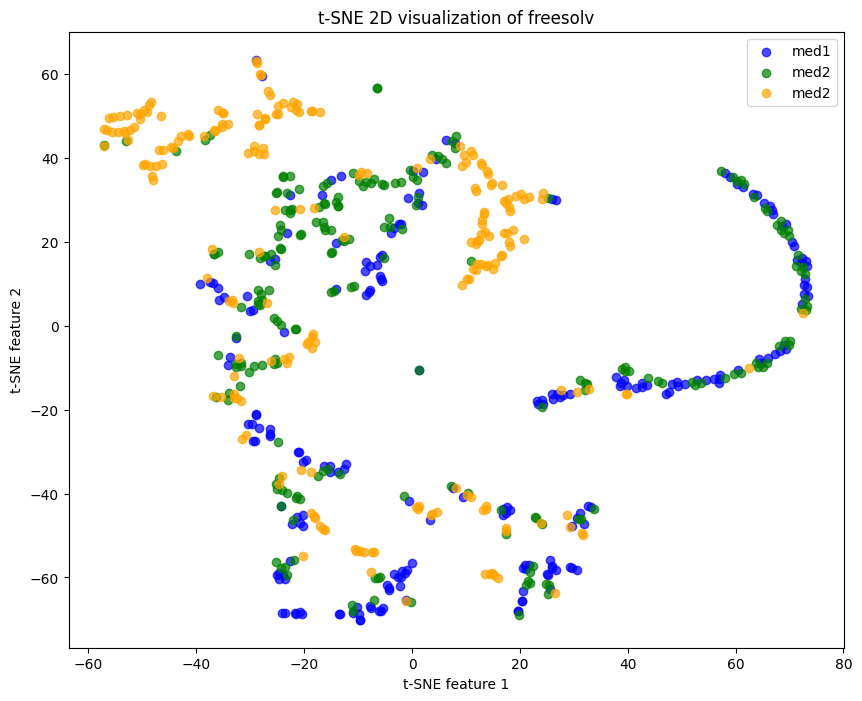

In [15]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.scatter(X_tsne[idx_med4, 0], X_tsne[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_med5, 0], X_tsne[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax.scatter(X_tsne[idx_med6, 0], X_tsne[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 2D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend()
plt.show()

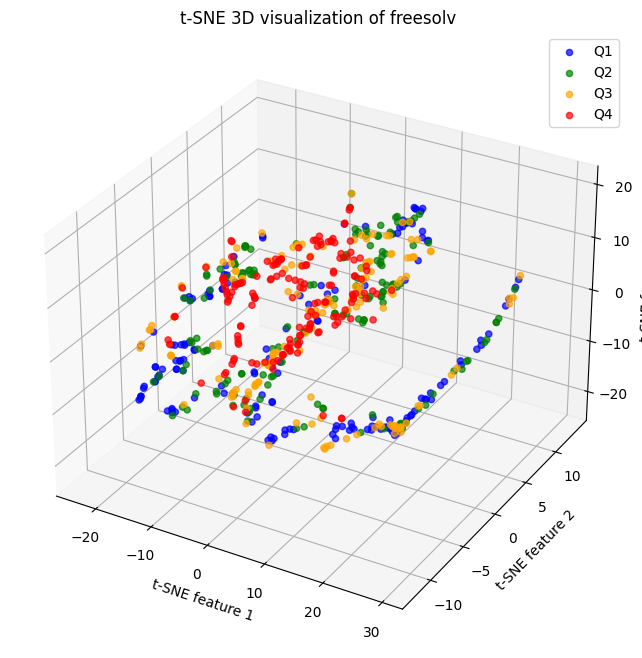

In [16]:

# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne3D[idx_Q1, 0], X_tsne3D[idx_Q1, 1], X_tsne3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax.scatter(X_tsne3D[idx_Q2, 0], X_tsne3D[idx_Q2, 1], X_tsne3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax.scatter(X_tsne3D[idx_Q3, 0], X_tsne3D[idx_Q3, 1], X_tsne3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax.scatter(X_tsne3D[idx_Q4, 0], X_tsne3D[idx_Q4, 1], X_tsne3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax.set_title(f't-SNE 3D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

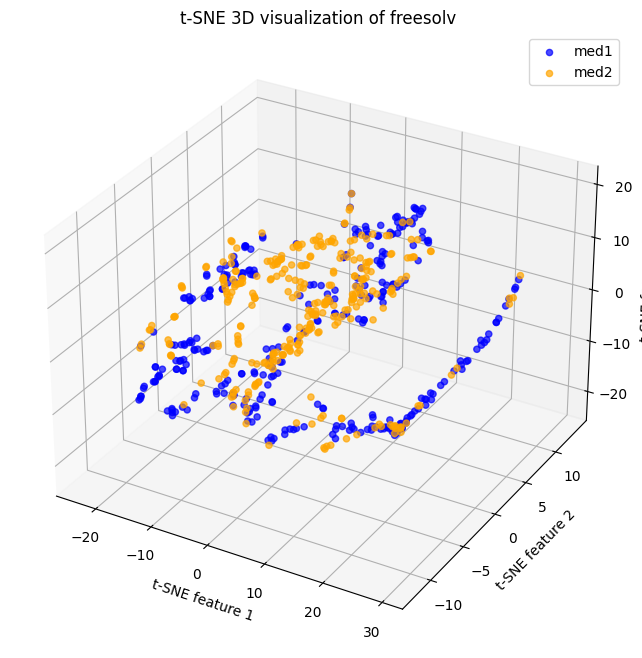

In [17]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne3D[idx_med1, 0], X_tsne3D[idx_med1, 1], X_tsne3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne3D[idx_med2, 0], X_tsne3D[idx_med2, 1], X_tsne3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 3D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

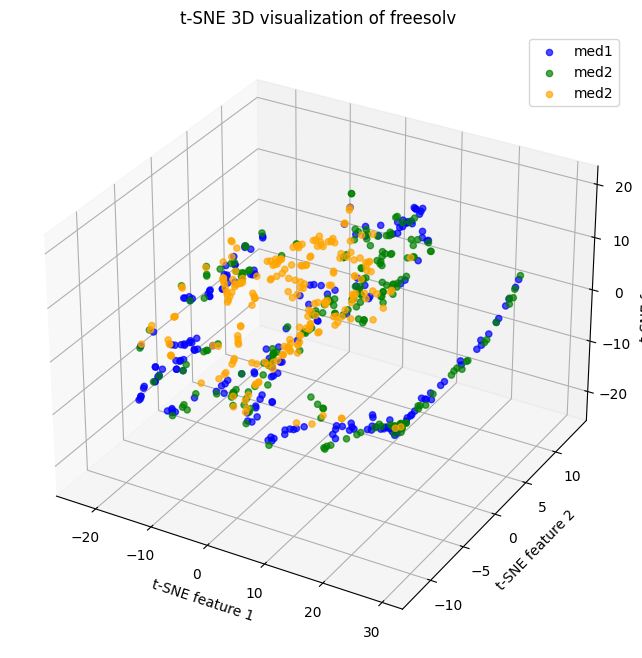

In [18]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne3D[idx_med4, 0], X_tsne3D[idx_med4, 1], X_tsne3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne3D[idx_med5, 0], X_tsne3D[idx_med5, 1], X_tsne3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax.scatter(X_tsne3D[idx_med6, 0], X_tsne3D[idx_med6, 1], X_tsne3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 3D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

In [19]:
bins = pd.qcut(df_all_features['target'], q=4, labels=["Low", "Mid-low", "Mid-high", "High"])


In [20]:
bins = pd.cut(df_all_features['target'], bins=3, labels=["Low", "Mid-low", "Mid-high"])


In [21]:

# import seaborn as sns

# # t-SNE 임베딩
# X_embedded = TSNE(n_components=2, random_state=0).fit_transform(X)

# # 분위수로 나눔
# df_all_features['quantile_group'] = bins

# # 시각화
# sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_all_features['quantile_group'])
# plt.title("t-SNE projection with quantile-based color grouping")
# plt.show()


In [27]:
from sklearn.cluster import KMeans
import numpy as np
target_reshaped = df_all_features['target'].values.reshape(-1, 1)


df_all_features['kmeans_bin'] = KMeans(n_clusters=4).fit_predict(target_reshaped)

c:\Programming\Anaconda\envs\egcn\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Programming\Anaconda\envs\egcn\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [28]:
df_all_features

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target,kmeans_bin
0,11.429183,0.002457,11.429183,0.002457,0.686360,179.219,166.115,179.094629,70,0,...,0,0,0,0,0,0,0,0,-11.01,2
1,9.397377,-3.194444,9.397377,0.925154,0.421427,114.553,111.529,113.954228,32,0,...,0,0,0,0,0,0,0,0,-4.87,0
2,3.560185,0.648148,3.560185,0.648148,0.412737,70.135,60.055,70.078250,30,0,...,0,0,0,0,0,0,0,0,1.83,1
3,4.034722,0.966111,4.034722,0.966111,0.536795,108.144,100.080,108.068748,42,0,...,0,0,0,0,0,0,0,0,-5.45,0
4,8.365587,0.364796,8.365587,0.364796,0.544191,116.204,100.076,116.120115,50,0,...,0,0,0,0,0,0,3,0,-4.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,10.622272,-0.081946,10.622272,0.081946,0.438315,158.241,140.097,158.130680,66,0,...,0,0,0,0,0,0,3,0,-2.04,0
638,3.222222,1.250000,3.222222,1.250000,0.434794,71.123,62.051,71.073499,30,0,...,0,0,0,0,0,0,0,0,-5.48,0
639,10.036149,0.181111,10.036149,0.181111,0.568137,122.123,116.075,122.036779,46,0,...,0,0,0,0,0,0,0,0,-8.83,2
640,5.480456,0.837018,5.480456,0.837018,0.400312,134.650,119.530,134.086228,50,0,...,0,0,0,0,0,0,3,0,0.29,1


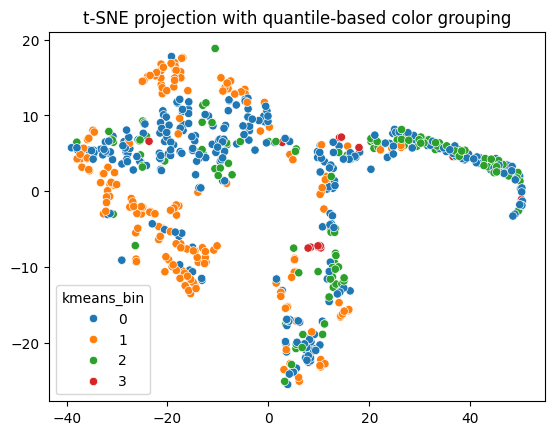

In [34]:

import seaborn as sns

# t-SNE 임베딩
X_embedded = TSNE(n_components=2, random_state=0).fit_transform(X)

# 분위수로 나눔

# 시각화
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_all_features['kmeans_bin'],palette='tab10')
plt.title("t-SNE projection with quantile-based color grouping")
plt.show()
